In [1]:
import math
import datetime
import numpy as onp
import pandas as pd
import jax.numpy as np
from jax import grad, jit, vmap, jacfwd, jacrev
import jax.random as random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
tqdm.pandas()
import io
np.set_printoptions(precision=2)

from google.colab import files
uploaded = files.upload()
rides = pd.read_csv(io.BytesIO(uploaded['rideshare_kaggle.csv']))
print('Done Uploading')

Saving rideshare_kaggle.csv to rideshare_kaggle.csv
Done Uploading


# Preprocessing data

In [2]:
rides = pd.read_csv('rideshare_kaggle.csv')
print(rides)

                                          id  ...  apparentTemperatureMaxTime
0       424553bb-7174-41ea-aeb4-fe06d4f4b9d7  ...                  1544958000
1       4bd23055-6827-41c6-b23b-3c491f24e74d  ...                  1543251600
2       981a3613-77af-4620-a42a-0c0866077d1e  ...                  1543320000
3       c2d88af2-d278-4bfd-a8d0-29ca77cc5512  ...                  1543510800
4       e0126e1f-8ca9-4f2e-82b3-50505a09db9a  ...                  1543420800
...                                      ...  ...                         ...
693066  616d3611-1820-450a-9845-a9ff304a4842  ...                  1543690800
693067  633a3fc3-1f86-4b9e-9d48-2b7132112341  ...                  1543690800
693068  64d451d0-639f-47a4-9b7c-6fd92fbd264f  ...                  1543690800
693069  727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e  ...                  1543690800
693070  e7fdc087-fe86-40a5-a3c3-3b2a8badcbda  ...                  1543690800

[693071 rows x 57 columns]


In [3]:
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)
new_rides = rides[['source','destination','cab_type','price','date']].dropna(subset = ['price']).reset_index()
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)


companies_ = new_rides.cab_type.unique()
sources_ = ['Haymarket Square']  # new_rides.source.unique()
destinations_ = new_rides.destination.unique()
dates_ = new_rides.date.unique()[0:14]
prices_ = prices_ = np.array([5+5*(i+1) for i in range(5)])

q = onp.empty((len(companies_),len(dates_),len(sources_),len(prices_)))
avg_price = onp.empty((len(companies_),len(dates_),len(sources_),len(prices_)))

for i in range(len(companies_)):
  for j in trange(len(dates_)):
    for k in range(len(sources_)):
      for l in range(len(prices_)):
        q[i,j,k,l] = len(new_rides[(new_rides['cab_type']==companies_[i])
                                  &(new_rides['date']==dates_[j])
                                  &(new_rides['source']==sources_[k])
                                  &(new_rides['price']==prices_[l])])

q_bar = np.mean(q,axis=1)

100%|██████████| 14/14 [00:08<00:00,  1.72it/s]


In [4]:
q_lyft = q[0]
q_uber = q[1]

q_bar_lyft = q_bar[0]
q_bar_uber = q_bar[1]

q_lyft_centered = (q_lyft-q_bar_lyft).reshape((len(dates_),-1))
q_uber_centered = (q_uber-q_bar_uber).reshape((len(dates_),-1))

# Helper functions

## Loss and Oracles

In [5]:
def base_demand(q_centered, key, n=5):
  key, subkey = random.split(key)
  idx = random.randint(key,[n,q_centered.shape[1]],0,len(dates_))
  q = np.mean(q_lyft_centered[idx,[i for i in range(q_centered.shape[1])]],axis=0).reshape((-1,1))
  return q, key

def location_family_demand(q, theta_i, theta_j, mu_i, gamma_i):
  """
  Sample the demand for a ride with base demand q from the parametrized location family

  Input:
    q_i \in R^d_i, the base demand where q_i[k] is the demand for rides with features x_k
    theta_i \in R^d_i, the strategy for player i
    theta_j \in R^d_j, the strategy for player j
    mu_i \in R^{d_ixd_i}, the performative effects of player i on player i
    gamma_i \in R^{d_ixd_j}, the performative effects of player(s) -i on player i
  Output:
    demand \in R^d_i, the demand after performative effects for each x_k
  """
  demand = q + np.dot(mu_i,theta_i) + np.dot(gamma_i,theta_j)
  return demand

def loss(theta, demand_centered, avg_demand, prices, lambda_r):
  """
  Return the negative revenue loss for a particular theta_i and sampled demand

  Input:
    theta \in R^d_i, the player's strategy (price adjustments)
    demand \in R^d_i, the sampled demands for each of d sets of features x_k
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter
  Output:
    l \in R, the loss (-revenue + regularization)
  """
  if np.any(theta):
    l = -np.dot((avg_demand+demand_centered).T,prices+theta)+(lambda_r/2)*(np.linalg.norm(theta)**2)
  else:
    l = -np.dot((avg_demand+demand_centered).T,prices)
  return l[0,0]

def oracle_loss(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Return 1 sample of the loss for a particular strategy profile and set of ride features
  Input:
    theta_i \in R^d_i, the strategy for player i
    theta_j \in R^d_j, the strategy for player j
    q_i \in R^d_i, the base demand where q_i[k] is the demand for rides with features x_k
    mu_i \in R^{d_ixd_i}, the performative effects of player i on player i
    gamma_i \in R^{d_ixd_j}, the performative effects of player(s) -i on player i
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    l \in R, the loss (-revenue + regularization)
  """
  demand_centered = location_family_demand(q_centered,theta_i,theta_j,mu,gamma)
  l = loss(theta_i,demand_centered,q_bar,prices,lambda_r)
  return l

def oracle_gradient(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Total gradient of the loss with respect to theta_i

  Input:
    theta_k \in R^d_k
    mu \in R^{d_ixd_i}
    gamma \in R^{d_ixd_j}
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter,
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    grad_l \in R^d_i, the gradient of the loss with respect to theta_i
  """
  grad_l = grad(oracle_loss)(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar)
  return grad_l

def oracle_hessian(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar):
  """
  Hessian of the loss with respect to theta_i

  Input:
    theta_k \in R^d_k
    mu \in R^{d_ixd_i}
    gamma \in R^{d_ixd_j}
    prices \in R^d_i, the worst-case prices for rides with features x_k
    lambda_r \in R, the regularization parameter,
    rides, the dataframe of rides
    x, a matrix describing the features of rides
  Output:
    grad_l \in R^d_ixd_i, the hessian of the loss with respect to theta_i
  """
  hessian_i = jacfwd(jacrev(oracle_loss))(theta_i, theta_j, mu, gamma, prices, lambda_r, q_centered, q_bar)
  return hessian_i

def Pi_Theta(theta_i,R_i):
  """
  Project theta onto a 2-norm ball of radius R

  Input:
    theta_i \in R^d_i
    R_i \in R_+, the radius of Theta_i
  Output:
    Pi_Theta_i(theta_i), the projection of theta_i onto the ball of radius R_i
  """
  if np.linalg.norm(theta_i)>R_i:
    return R_i*(theta_i/np.linalg.norm(theta_i))
  else:
    return theta_i

# Adaptive Gradient Play Implementation

In [6]:
def perturb_theta(B, key):
  """
  Sample a normal random vector u with covariance B

  Input:
    B \in S^d_+, the covariance of u
    key, a jax random number generator key 
  Output:
    u \in R^d, the injected noise
    key, a new jax random number generator key
  """
  d = B.shape[0]
  key, subkey = random.split(key)
  v = random.normal(subkey,shape=(d,1))
  u = np.dot(B,v)
  return u, key

def compute_q_hat(demand,mu_hat,gamma_hat,theta_i,theta_j,u_i,u_j):
  """
  Compute an estimate for q for one player

  Input:
    demand \in R^d_i, the sampled oracle demands for player i
    mu_hat \in R^d_i, the estimated mu for player i
    gamma_hat \in R^d_i, the estimated gamma for player i
    theta_k \in R^d_k, the strategy for player k
    u_k \in R^d_k, the perturbations for theta_k
  Output:
    q_hat \in R^d_i, the estimated base demands for player i
  """
  q_hat = demand - np.dot(mu_hat,theta_i+u_i) - np.dot(gamma_hat,theta_j+u_j)
  return q_hat

def update_p_hat(p_hat,demand,theta_i,theta_j,u_i,u_j,nu):
  """
  Update the estimate of p = [mu, gamma]

  Input:
  p_hat \in R^{d_ixd}, the previous estimate for p_hat
  demand \in R^d_i, the sampled demands for player i
  theta_k \in R^d_k
  u_k \in R^d_k
  nu \in R, stepsize
  """
  theta = np.vstack([theta_i,theta_j])
  u = np.vstack([u_i,u_j])
  p_hat_new = p_hat + nu*np.dot((demand-np.dot(p_hat,theta+u)),(theta+u).T)
  return p_hat_new

def grad_update(theta_i, theta_j, eta, q_hat, q_bar, p_hat, prices, lambda_r, R_i):
  """
  Individual gradient step for player i

  Input:
    theta_i \in R^d_i, the previous strategy for player i
    eta \in R, the step size
    gradient \in R^d_i, the gradient of the perturbed loss with respect to theta_i
    proj, a function that projects the updated theta_i onto Theta_i
  Output:
    theta_i_new \in R^d_i, the updated strategy for player i
  """
  d_i = np.shape(theta_i)[0]
  mu_hat, gamma_hat = np.split(p_hat, [d_i], axis=1)
  gradient = oracle_gradient(theta_i,theta_j,mu_hat,gamma_hat,prices,lambda_r,q_hat,q_bar)
  theta_i_new = Pi_Theta(theta_i - eta*gradient, R_i)
  return theta_i_new

# Adaptive Gradient Play

In [7]:
T = 2000
N = 2
key = random.PRNGKey(46)

d_1 = q_bar_uber.shape[1]
d_2 = q_bar_lyft.shape[1]
D = d_1+d_2
d_ = [d_1,d_2]

key, subkey = random.split(key)
noise1 = 2.0*random.normal(subkey,(d_1,d_2))
key, subkey = random.split(key)
noise2 = 2.0*random.normal(subkey,(d_1,d_2))
mu = [-noise1+np.diagflat((-3*q_bar_uber.squeeze())/(2*np.array(prices_))),
      -noise2+np.diagflat((-3*q_bar_lyft.squeeze())/(2*np.array(prices_)))]
gamma = [noise1+np.diagflat((3*q_bar_lyft.squeeze())/(4*np.array(prices_))),
         noise2+np.diagflat((3*q_bar_uber.squeeze())/(4*np.array(prices_)))]

prices = [prices_.reshape((-1,1)), prices_.reshape((-1,1))]

lambda_r = 20.0
q_bar = [q_bar_uber, q_bar_lyft]
q_centered = [q_uber_centered, q_lyft_centered]
q = [np.zeros((d_1,1)), np.zeros((d_2,1))]

theta = [np.zeros((d_1,1)), np.zeros((d_2,1))]
u = [np.zeros((d_1,1)), np.zeros((d_2,1))]
mu_hat = [np.diagflat(np.zeros(d_1)), np.diagflat(np.zeros(d_2))]
gamma_hat = [np.diagflat(np.zeros(d_2)), np.diagflat(np.zeros(d_1))]
p_hat = [np.zeros((d_1,D)), np.zeros((d_2,D))]
q_hat = [np.zeros((d_1,1)), np.zeros((d_2,1))]
z_t = [np.zeros((d_1,1)), np.zeros((d_2,1))]

B = [5.0*np.eye(d_1), 5.0*np.eye(d_2)]
eta = [1e-4, 1e-4]
nu = [1e-3, 1e-3]

R = 1e6

theta_1_history = []
q_1_history = []
q_1_hat_history = []
mu_1_hat_history = []
gamma_1_hat_history = []
grad_1_history = []
hessian_1_history = []

theta_2_history = []
q_2_history = []
q_2_hat_history = []
mu_2_hat_history = []
gamma_2_hat_history = []
grad_2_history = []
hessian_2_history = []

for t in trange(T):
  for i in [0,1]:
    j = (i+1)%2
    u[i], key = perturb_theta(B[i], key)
    q[i], key = base_demand(q_centered[i], key)
    # q[i] = np.zeros((d_[i],1))

  for i in [0,1]:
    j = (i+1)%2
    z_t[i] = location_family_demand(q[i],theta[i]+u[i],theta[j]+u[j],mu[i],gamma[i])
    q_hat[i] = compute_q_hat(z_t[i],mu_hat[i],gamma_hat[i],theta[i],theta[j],u[i],u[j])
    p_hat[i] = update_p_hat(p_hat[i],z_t[i],theta[i],theta[j],u[i],u[j],nu[i])
    mu_hat[i], gamma_hat[i] = np.split(p_hat[i], [d_[i]], axis=1)
    theta[i] = grad_update(theta[i],theta[j],eta[i],q_hat[i],q_bar[i],p_hat[i],prices[i],lambda_r,R)
    gradient_t = oracle_gradient(theta[i],theta[j],mu_hat[i],gamma_hat[i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[i])
    hessian_t = oracle_hessian(theta[i],theta[j],mu_hat[i],gamma_hat[i],prices[i],lambda_r,np.zeros((d_[i],1)),q_bar[i])
    if i==0:
      q_1_history.append(q[i])
      q_1_hat_history.append(q_hat[i])
      mu_1_hat_history.append(mu_hat[i])
      gamma_1_hat_history.append(gamma_hat[i])
      theta_1_history.append(theta[i])
      grad_1_history.append(gradient_t)
      hessian_1_history.append(hessian_t)
    else:
      q_2_history.append(q[i])
      q_2_hat_history.append(q_hat[i])
      mu_2_hat_history.append(mu_hat[i])
      gamma_2_hat_history.append(gamma_hat[i])
      theta_2_history.append(theta[i])
      grad_2_history.append(gradient_t)
      hessian_2_history.append(hessian_t)

100%|██████████| 2000/2000 [03:52<00:00,  8.59it/s]


# Adaptive Gradient Play Plots

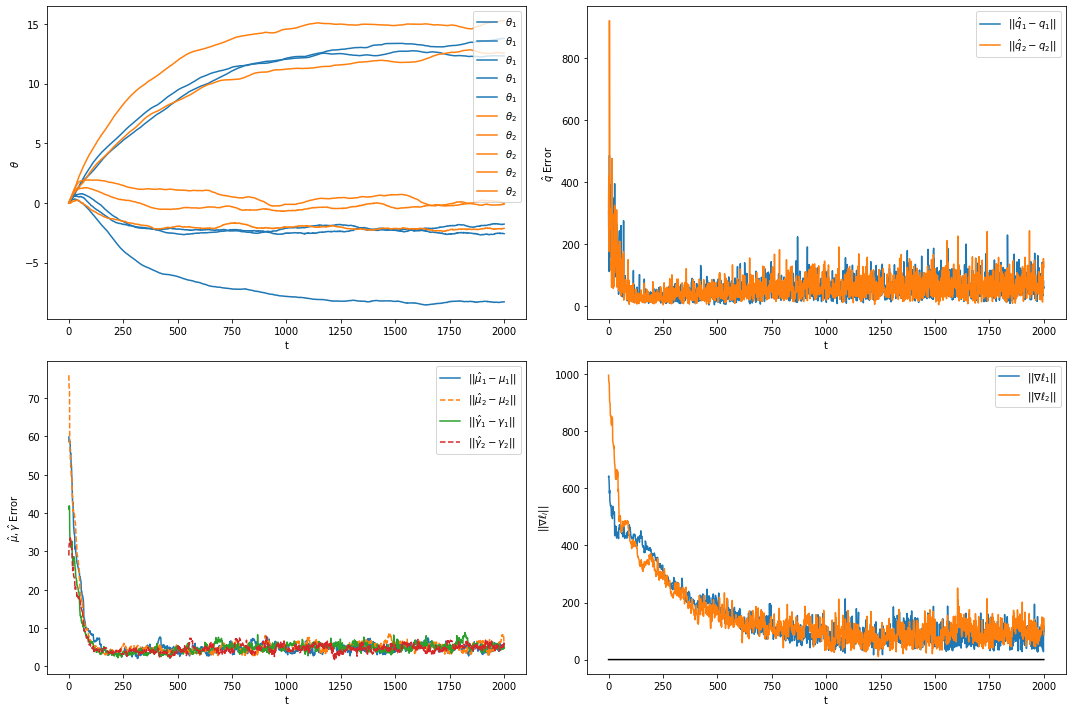

In [8]:
q_1_error = [np.linalg.norm(q_1_hat_history[i]-q_1_history[i]) for i in range(len(q_1_hat_history))]
q_2_error = [np.linalg.norm(q_2_hat_history[i]-q_2_history[i]) for i in range(len(q_2_hat_history))]
mu_1_error = [np.linalg.norm(mu_1_hat_history[i]-mu[0]) for i in range(len(mu_1_hat_history))]
gamma_1_error = [np.linalg.norm(gamma_1_hat_history[i]-gamma[0]) for i in range(len(gamma_1_hat_history))]
mu_2_error = [np.linalg.norm(mu_2_hat_history[i]-mu[1]) for i in range(len(mu_2_hat_history))]
gamma_2_error = [np.linalg.norm(gamma_2_hat_history[i]-gamma[1]) for i in range(len(gamma_2_hat_history))]

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,10))
ax1.plot(np.linspace(0,T,T),np.array(theta_1_history).squeeze(),label=r'$\theta_1$',color='tab:blue')
ax1.plot(np.linspace(0,T,T),np.array(theta_2_history).squeeze(),label=r'$\theta_2$',color='tab:orange')
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\theta$')
ax1.legend()
ax2.plot(np.linspace(0,T,T),q_1_error,label=r'$||\hat{q}_1-q_1||$')
ax2.plot(np.linspace(0,T,T),q_2_error,label=r'$||\hat{q}_2-q_2||$')
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\hat{q}$ Error')
ax2.legend()
ax3.plot(np.linspace(0,T,T),mu_1_error,label=r'$||\hat{\mu}_1-\mu_1||$')
ax3.plot(np.linspace(0,T,T),mu_2_error,'--',label=r'$||\hat{\mu}_2-\mu_2||$')
ax3.plot(np.linspace(0,T,T),gamma_1_error,label=r'$||\hat{\gamma}_1-\gamma_1||$')
ax3.plot(np.linspace(0,T,T),gamma_2_error,'--',label=r'$||\hat{\gamma}_2-\gamma_2||$')
ax3.set_xlabel('t')
ax3.set_ylabel(r'$\hat{\mu},\hat{\gamma}$ Error')
ax3.legend()
ax4.plot(np.linspace(0,T,T),[np.linalg.norm(grad_1_history[i]) for i in range(T)],label=r'$||\nabla\ell_1||$')
ax4.plot(np.linspace(0,T,T),[np.linalg.norm(grad_2_history[i]) for i in range(T)],label=r'$||\nabla\ell_2||$')
ax4.plot(np.linspace(0,T,T),[0 for i in range(T)],color='k')
ax4.set_xlabel('t')
ax4.set_ylabel(r'$||\nabla\ell_i||$')
ax4.legend()
plt.tight_layout()
plt.show()

## SGD With Sampling Bias

In [9]:
T = 2000
N = 2
key = random.PRNGKey(46)

theta_sgd = [np.zeros((d_1,1)), np.zeros((d_2,1))]

eta = [1e-4, 1e-4]

p = [np.hstack([mu[0],gamma[0]]), np.hstack([mu[1],gamma[1]])]

R = 1e6

theta_1_sgd_history = []
theta_2_sgd_history = []

for t in trange(T):
  for i in [0,1]:
    j = (i+1)%2
    q[i], key = base_demand(q_centered[i], key)
    # q[i] = np.zeros((d_[i],1))
    theta_sgd[i] = grad_update(theta_sgd[i],theta_sgd[j],eta[i],q[i],q_bar[i],p[i],prices[i],lambda_r,R)
    if i==0:
      theta_1_sgd_history.append(theta_sgd[i])
    else:
      theta_2_sgd_history.append(theta_sgd[i])

100%|██████████| 2000/2000 [01:06<00:00, 30.08it/s]


# SGD Plots

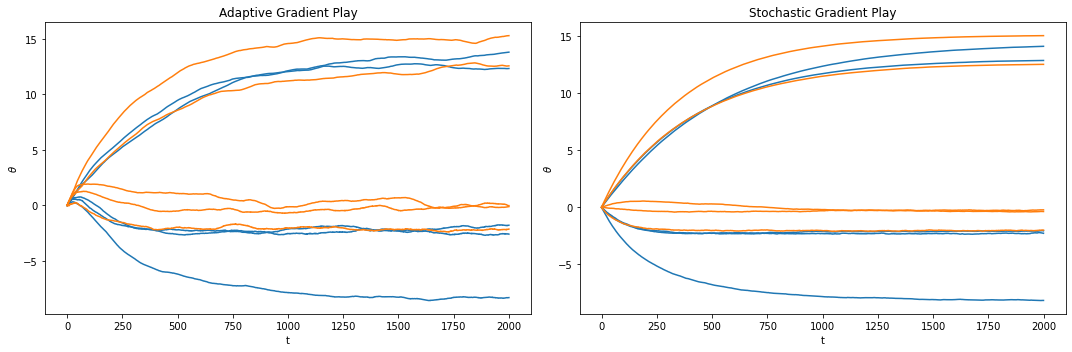

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(np.linspace(0,T,T),np.array(theta_1_history).squeeze(),label=r'$\theta_1$',color='tab:blue')
ax1.plot(np.linspace(0,T,T),np.array(theta_2_history).squeeze(),label=r'$\theta_2$',color='tab:orange')
# ax1.set_ylim(-200,200)
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\theta$')
ax1.set_title('Adaptive Gradient Play')
# ax1.legend()
ax2.plot(np.linspace(0,T,T),np.array(theta_1_sgd_history).squeeze(),label=r'$\theta_1$',color='tab:blue')
ax2.plot(np.linspace(0,T,T),np.array(theta_2_sgd_history).squeeze(),label=r'$\theta_2$',color='tab:orange')
# ax2.set_ylim(-200,200)
ax2.set_xlabel('t')
ax2.set_ylabel(r'$\theta$')
ax2.set_title('Stochastic Gradient Play')
# ax2.legend()
plt.tight_layout()
plt.show()

In [11]:
print('Gradient R(theta_{SGD}) = ','\n',oracle_gradient(theta_sgd[0],theta_sgd[1],mu[0],gamma[0],prices[0],lambda_r,np.zeros((d_[0],1)),q_bar[0]))
print('Hessian R(theta_{SGD}) = ','\n',oracle_hessian(theta_sgd[0],theta_sgd[1],mu[0],gamma[0],prices[0],lambda_r,np.zeros((d_[0],1)),q_bar[0]).squeeze())
print(f'Hessian Eigvals SGD = {np.linalg.eigvals(oracle_hessian(theta_sgd[0],theta_sgd[1],mu[0],gamma[0],prices[0],lambda_r,np.zeros((d_[0],1)),q_bar[0]).squeeze())}')

Gradient R(theta_{SGD}) =  
 [[-0.99]
 [ 0.51]
 [-3.48]
 [ 0.32]
 [-5.11]]
Hessian R(theta_{SGD}) =  
 [[ 1.15e+02 -2.60e+00  8.95e-01  1.51e+00 -1.10e+00]
 [-2.60e+00  8.37e+01 -5.45e-01  4.64e+00  6.60e-03]
 [ 8.95e-01 -5.45e-01  2.77e+01  5.55e-01 -2.46e+00]
 [ 1.51e+00  4.64e+00  5.55e-01  5.73e+01  5.59e+00]
 [-1.10e+00  6.60e-03 -2.46e+00  5.59e+00  2.20e+01]]
Hessian Eigvals SGD = [114.92+0.j  84.32+0.j  57.33+0.j  28.57+0.j  20.24+0.j]


In [12]:
print('nabla R(theta_{OL}) = ','\n',oracle_gradient(theta[0],theta[1],mu[0],gamma[0],prices[0],lambda_r,q[0],q_bar[0]))
print('Hessian R(theta_{OL}) = ','\n',oracle_hessian(theta[0],theta[1],mu[0],gamma[0],prices[0],lambda_r,np.zeros((d_[0],1)),q_bar[0]).squeeze())
print(f'Hessian Eigvals OL = {np.linalg.eigvals(oracle_hessian(theta[0],theta[1],mu[0],gamma[0],prices[0],lambda_r,np.zeros((d_[0],1)),q_bar[0]).squeeze())}')

nabla R(theta_{OL}) =  
 [[ 51.34]
 [104.72]
 [-16.48]
 [ 23.92]
 [ -8.36]]
Hessian R(theta_{OL}) =  
 [[ 1.15e+02 -2.60e+00  8.95e-01  1.51e+00 -1.10e+00]
 [-2.60e+00  8.37e+01 -5.45e-01  4.64e+00  6.60e-03]
 [ 8.95e-01 -5.45e-01  2.77e+01  5.55e-01 -2.46e+00]
 [ 1.51e+00  4.64e+00  5.55e-01  5.73e+01  5.59e+00]
 [-1.10e+00  6.60e-03 -2.46e+00  5.59e+00  2.20e+01]]
Hessian Eigvals OL = [114.92+0.j  84.32+0.j  57.33+0.j  28.57+0.j  20.24+0.j]


In [13]:
print(np.mean(np.array(grad_1_history[-1000:]),axis=0))
print(np.mean(np.array(grad_2_history[-1000:]),axis=0))

[[ -0.88]
 [ -3.3 ]
 [ -2.9 ]
 [  4.58]
 [-16.71]]
[[  1.26]
 [ -6.32]
 [ -7.05]
 [  0.15]
 [-13.38]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a st

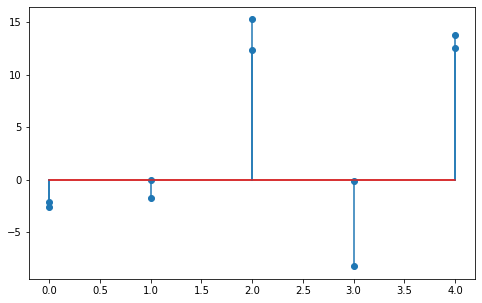

In [14]:
plt.figure(figsize=(8,5))
plt.stem(theta[0])
plt.stem(theta[1])
plt.show()

In [15]:
theta[0]

DeviceArray([[-2.58],
             [-1.78],
             [12.33],
             [-8.29],
             [13.79]], dtype=float32)

In [16]:
theta[1]

DeviceArray([[-2.13],
             [-0.03],
             [15.28],
             [-0.1 ],
             [12.56]], dtype=float32)